<a href="https://colab.research.google.com/github/jeffbmartinez/ibm-ai-eng-cert/blob/main/AI_capstone_M1L1_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: center;">
  <a href="https://cognitiveclass.ai/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="400">
  </a>
</div>



<h1 align=left><font size = 5>Compare Memory-Based versus Generator-Based Data Loading</font></h1>


<h5>Estimated time: 30 minutes</h5>


<h2>Learning objective</h2>
After completing this lab, you'll be able to:

- Download and manage satellite image datasets using Keras and Python libraries
- Compare memory-based and generator-based data loading strategies in terms of performance, memory efficiency, and implementation complexity
- Build a simple, memory-efficient image pipeline by loading and visualizing geospatial image data sequentially
- Assess the trade-offs between loading entire image datasets into memory versus accessing image paths on demand


## Introduction


Geospatial data analysis is a highly competitive and growing sector. It is used for land cover mapping, building roads, detection, and temporal land usage monitoring, among other applications. In this lab, you will learn to efficiently build a classifier by training a model from a curated dataset. For problem formulation, you will use images to denote agricultural land vs. non-agricultural land.

Additionally, you will learn to download a dataset from the cloud. The notebook will illustrate two common ways to work with image datasets in Python: Loading file paths and opening images one by one, which is sequential loading and holding all images in memory at once, which is bulk loading. You will learn how each approach affects code simplicity, memory use, and I/O performance.

**Note:** Throughout this lab, you’ll answer strategically placed questions designed to reinforce your learning and complete the quiz.


## Table of contents

<font size = 3>    

1. [Import libraries and packages](#Import-libraries-and-packages)
2. [Download data](#Download-data)
3. [Load images](#Load-images)

</font>
</div>


### Install the required libraries

All the required libraries are __not__ pre-installed in the Skills Network Labs environment. __You need to run the following cell__ to install them, and this might take a few minutes.


In [1]:
%%capture captured_output
# !pip install numpy==1.26
# !pip install matplotlib==3.9.2
!pip install skillsnetwork

In [2]:
output_text = captured_output.stdout
lines = output_text.splitlines()
output_last_10_lines = '\n'.join(lines[-10:])
if "error" in output_last_10_lines.lower():
    print("Library installation failed!")
    print("--- Error Details ---")
    print(output_last_10_lines)
else:
    print("Library installation was successful, let's proceed ahead")

Library installation was successful, let's proceed ahead


## Import libraries and packages


Let's begin by importing the libraries and packages that you will need to complete the rest of this lab.


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skillsnetwork

from PIL import Image

## Download data


The data is on a cloud server. You can retrieve and unzip it easily using the **skillsnetwork.prepare** command. So, let's run the following line of code to download the data.


In [4]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/5vTzHBmQUaRNJQe5szCyKw/images-dataSAT.tar"

extraction_path = "."
await skillsnetwork.prepare(url = url, path = extraction_path, overwrite = True)

  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to '.'


Now, you will be able to see the **images_dataSAT** folder in the left pane. It has two folders  **class_0_non_agri** and **class_1_agri**.
The folder structure looks as follows:

```python
images_dataSAT/
├── class_0_non_agri/
└── class_1_agri/

```

<table>
    <tr>
        <td style="text-align:center;"><b>Primary folder</b></td>
        <td style="text-align:center;"><b>Subfolders</b></td>
    </tr>
    <tr>
        <td><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/owykkC4Pr2zxLtU6vskQ5A/DL0321EN-M1L1-file-tree-Screenshot-1.png" style="width:300px; border:0px solid black;"></td>
        <td><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/okqnadJpvAeedGUXXYBIFg/DL0321EN-M1L1-file-tree-Screenshot-2.png" style="width:350px; border:0px solid black;"></td>
    </tr>
</table>


**class_0_non_agri** is the non-agricultural land class, as defined earlier, and it represents images with non-cultivable land.

**class_1_agri**, on the other hand, is the agricultural land class, and it represents the images with cultivable land.



<table>
    <tr>
        <td style="text-align:center;"><b>class_0_non_agri</b></td>
        <td style="text-align:center;"><b>class_1_agri</b></td>
    </tr>
    <tr>
        <td><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/1jSl6X5tUkVro8I_av8lEQ/DL0321EN-M1L1-file-tree-screenshot-3.png" style="width:300px; border:1px solid black;"></td>
        <td><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9f7sT5DBeFE_6Mp2OV3JKQ/DL0321EN-M1L1-file-tree-screenshot-4.png" style="width:300px; border:1px solid black;"></td>
    </tr>
</table>


**Note:** There are a few thousand images in each folder, so don't double-click on the folders. This may consume all of your memory, and you may end up with a **50*** error.


## Load images


Next, you will use the standard approach of loading all images in memory and demonstrate how this approach is not efficient when it comes to building deep learning models for classifying images.


In [5]:
# Define directories
extract_dir = "."

base_dir = os.path.join(extract_dir, 'images_dataSAT')
dir_non_agri = os.path.join(base_dir, 'class_0_non_agri')
dir_agri = os.path.join(base_dir, 'class_1_agri')

Let's start by reading in the non_agri images. First, you will use **os.scandir** to build an iterator to iterate through the *./images_dataSAT/class_0_non_agri* directory, which contains all the images with non-agriculture land.
Display the first 5 entries in the non_agri list


In [6]:
non_agri = os.scandir(dir_non_agri)
# print first 5 file paths
for f_path in range(5):
    print(next(non_agri))


<DirEntry 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_2392.jpg'>
<DirEntry 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_7705.jpg'>
<DirEntry 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_9488.jpg'>
<DirEntry 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_7481.jpg'>
<DirEntry 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_6387.jpg'>


Then, you will grab the first file in the directory.


In [7]:
file_name = next(non_agri)
file_name

<DirEntry 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_8407.jpg'>

Since the directory can contain elements that are not files, you only need to read the element if it is a file.


In [8]:
os.path.isfile(file_name)

True

Get the image name.


In [9]:
image_name = str(file_name).split("'")[1]
image_name

'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_8407.jpg'

Read within the image data.


array([[[147, 130, 136],
        [130, 115, 120],
        [149, 134, 137],
        ...,
        [ 95,  92,  87],
        [ 85,  82,  77],
        [ 65,  64,  59]],

       [[140, 125, 128],
        [138, 124, 124],
        [121, 109, 109],
        ...,
        [ 79,  76,  71],
        [ 74,  73,  68],
        [ 81,  80,  75]],

       [[122, 111, 107],
        [139, 130, 125],
        [128, 119, 114],
        ...,
        [ 74,  71,  66],
        [ 77,  76,  71],
        [ 93,  94,  88]],

       ...,

       [[117, 116, 147],
        [101, 101, 129],
        [143, 143, 171],
        ...,
        [182, 154, 169],
        [180, 143, 160],
        [188, 145, 164]],

       [[112, 111, 143],
        [147, 146, 177],
        [131, 130, 161],
        ...,
        [181, 150, 166],
        [188, 147, 165],
        [195, 150, 170]],

       [[ 83,  82, 114],
        [154, 153, 185],
        [ 87,  86, 117],
        ...,
        [178, 147, 163],
        [190, 147, 166],
        [197, 150, 170]]], dtype=uint8)
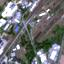

In [10]:
image_data = plt.imread(os.path.join(dir_non_agri, image_name))
image_data

### **Question 1**: What are the dimensions of a single image according to **image_data**?


In [11]:
## You can use this cell to type the code to answer the question.

image_data.shape

# The images are 64x64 pixels, with 3 channels

(64, 64, 3)

Double-click **here** for the solution.
<!--
print(image_data.shape)
-->


Let's take a look at the image.


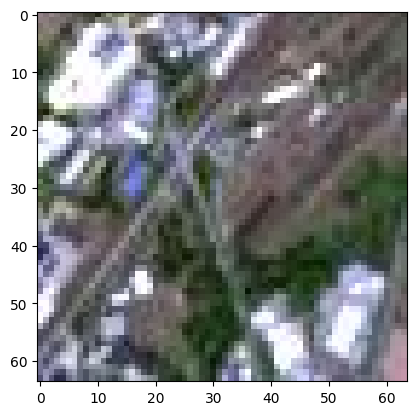

In [12]:
plt.imshow(image_data)

Now that you are familiar with the process of reading image data, let's loop through all the images in the *./images_dataSAT/class_0_non-agri* directory, read them all, and save them in the list **non_agri_images**. You will also need to note how long it takes to read all the images.


In [13]:
%%time

non_agri_images = []
for file_name in non_agri:
    if os.path.isfile(file_name):
        image_name = str(file_name).split("'")[1]
        image_data = plt.imread(os.path.join(dir_non_agri, image_name))
        non_agri_images.append(image_data)

non_agri_images = np.array(non_agri_images)

CPU times: user 1.31 s, sys: 240 ms, total: 1.55 s
Wall time: 1.96 s


Loading images into memory is not the right approach when working with images, as it takes a long time or can quickly exhaust memory and other resources. Therefore, let's repeat the previous process but save the paths to the images in a variable instead of loading and saving the individual images.


So, instead of using **os.scandir**, let's use **os.listdir**.


In [14]:
non_agri_images = os.listdir(dir_non_agri)
# print first 5 file paths
non_agri_images[:5]

['tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_2392.jpg',
 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_7705.jpg',
 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_9488.jpg',
 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_7481.jpg',
 'tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_6387.jpg']

Notice how the images are not sorted, so let's call the <code>sort</code> method to sort the images.


In [15]:
non_agri_images.sort()

# print first 5 file paths
non_agri_images[:5]

['tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_5902.jpg',
 'tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_6074.jpg',
 'tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_6246.jpg',
 'tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_6247.jpg',
 'tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_6248.jpg']

Before you can show an image, you need to open it. You can do this by using the **Image** module in the **PIL** library. To open the first image, run the following:


In [16]:
image_data = Image.open(os.path.join(dir_non_agri, non_agri_images[0]))

To view the image, run:


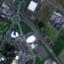

In [17]:
image_data

or use the <code>plt.imshow()</code> method as follows:


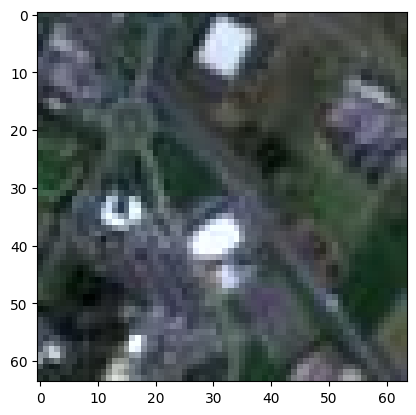

In [18]:
plt.imshow(image_data)

Let's loop through all the images in the <code>'./images_dataSAT/class_0_non_agri/'</code> directory and add their paths.


In [19]:
non_agri_images_paths = [os.path.join(dir_non_agri, image) for image in non_agri_images]
#print first five paths
non_agri_images_paths[:5]

['./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_5902.jpg',
 './images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_6074.jpg',
 './images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_6246.jpg',
 './images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_6247.jpg',
 './images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_6248.jpg']

Let's check how many images of non-agricultural land exist in the dataset.


In [20]:
len(non_agri_images_paths)

3000

### Question 2: Display the first four images in `'./images_dataSAT/class_0_non_agri/'` directory.


./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_5902.jpg


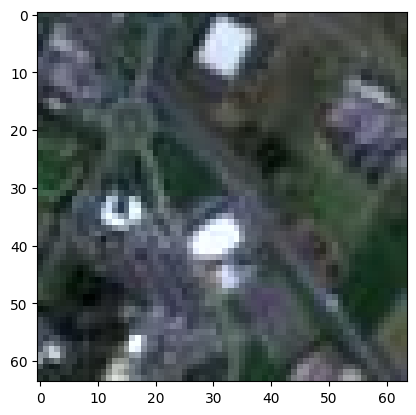


./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_6074.jpg


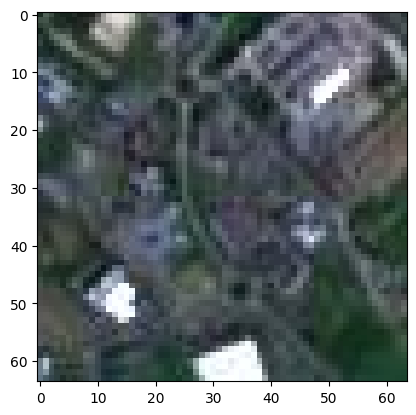


./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_6246.jpg


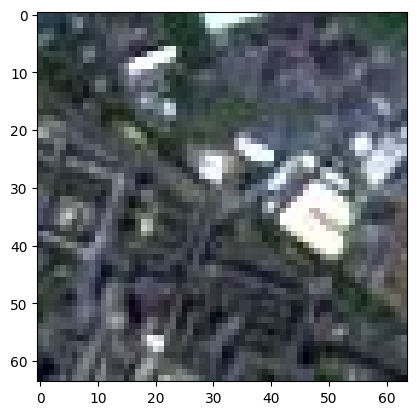


./images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_6247.jpg


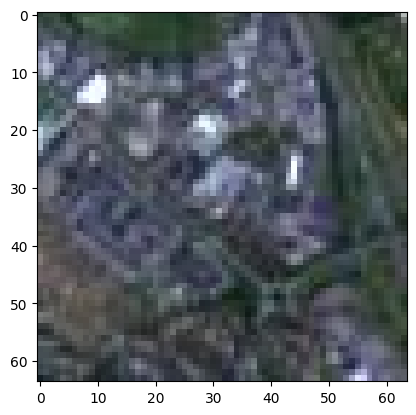

In [21]:
## You can use this cell to type the code to answer the question.

for image_path in non_agri_images_paths[0:4]:
    image_data = Image.open(image_path)

    print(image_path)
    plt.imshow(image_data)
    plt.show()
    print()


Double-click **here** for the solution.
<!--
n_images = 4
for image_path in non_agri_images[:n_images]:
    print(image_path)
    image_data = Image.open(os.path.join(dir_non_agri, image_path))
    plt.imshow(image_data)
    plt.show()
-->


### **Task 1**:
Save the paths to all the images in the `dir_agri` directory in a list called **agri_images_paths**. Make sure you sort the paths at the end.


In [22]:
## Type your answer here

agri_images = os.listdir(dir_agri)
agri_images.sort()

agri_images_paths = [os.path.join(dir_agri, image) for image in agri_images]

Double-click **here** for the solution.
<!--
agri_images_paths = []
for image in os.listdir(dir_agri):
    agri_images_paths.append(os.path.join(dir_agri, image))

agri_images_paths.sort()
-->


### Question 3: How many images of agricultural land exist in the <code>'./images_dataSAT/class_1_agri/'</code> directory?


In [23]:
## You can use this cell to type the code to answer the question.

len(agri_images_paths)

# 3000 images

3000

Double-click **here** for the solution.
<!--
print(len(agri_images_paths))
-->


### Question 4: Display the first four images of the agricultural land.


./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_5878.jpg


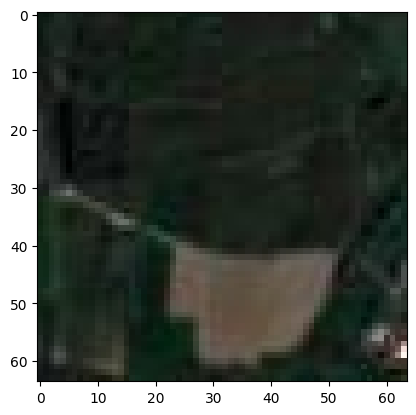


./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_5884.jpg


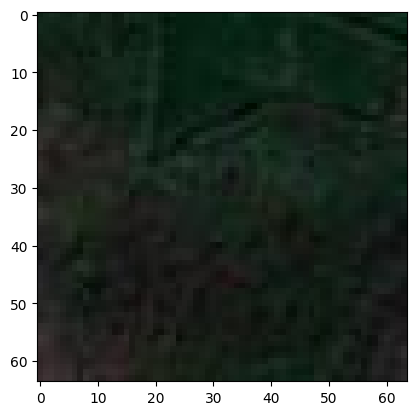


./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_6628.jpg


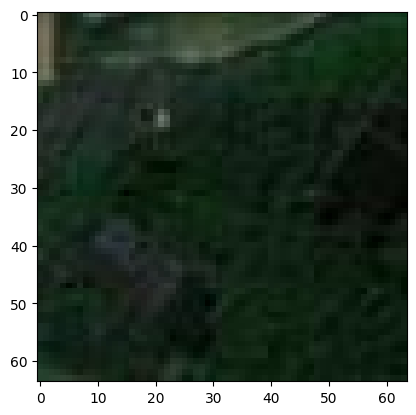


./images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250409T105701_N0511_R094_T31UDQ_20250409T173716.SAFE_6629.jpg


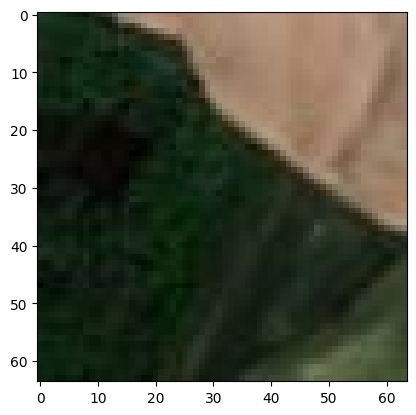

In [24]:
## You can use this cell to type the code to answer the question.

for image_path in agri_images_paths[0:4]:
    image_data = Image.open(image_path)

    print(image_path)
    plt.imshow(image_data)
    plt.show()
    print()

Double-click **here** for the solution.
<!--
n_images = 4
for image_path in agri_images_paths[:n_images]:
    print(image_path)
    image_data = Image.open(image_path)
    plt.imshow(image_data)
    plt.show()
-->


## Save and download the notebook for **final project** submission and evaluation

You will need to save and download the completed notebook for final project submission and evaluation.
<br>For saving and downloading the completed ntoebook, please follow the steps given below:</br>

<font size = 4>  

1) **Complete** all the tasks and questions given in the notebook.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/nv4jHlPU5_R1q7ZJrZ69eg/DL0321EN-M1L1-Save-IPYNB-Screenshot-1.png" style="width:600px; border:0px solid black;">

2) **Save** the notebook.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9-WPWD4mW1d-RV5Il5otTg/DL0321EN-M1L1-Save-IPYNB-Screenshot-2.png" style="width:600px; border:0px solid black;">

3) Identify and right click on the **correct notebook file** in the left pane.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/RUSRPw7NT6Sof94B7-9naQ/DL0321EN-M1L1-Save-IPYNB-Screenshot-3.png" style="width:600px; border:0px solid black;">

4) Click on **Download**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HHry4GT-vhLEcRi1T_LHGg/DL0321EN-M1L1-Save-IPYNB-Screenshot-4.png" style="width:600px; border:0px solid black;">

5) Download and **Save** the Jupyter notebook file on your computer **for final submission**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/hhsJbxc6R-T8_pXQGjMjvg/DL0321EN-M1L1-Save-IPYNB-Screenshot-5.png" style="width:600px; border:0px solid black;">
  </font>


### Congratulations!
You have successfully completed this lab.


### Summary

This notebook shows a memory-efficient and simple sequential loading pattern by sorting and indexing filenames and then opening images one by one. To compare, you can try a bulk-loading approach by reading all images into a single list of arrays to observe the trade-off between faster repeated access and higher memory usage.


### Thank you for completing this lab!

This notebook is part of an IBM course on **Coursera** called *AI Capstone Project with Deep Learning*.


<h2>Author</h2>

[Aman Aggarwal](https://www.linkedin.com/in/aggarwal-aman)

Aman Aggarwal is a PhD working at the intersection of neuroscience, AI, and drug discovery. He specializes in quantitative microscopy and image processing.


<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2025-06-25  | 1.0  | Aman  |  Created the lab |
| 2025-06-30  | 2.0  | Gagandeeep |  ID review |

-->


© Copyright IBM Corporation. All rights reserved.
